In [66]:
!pip install prophet

# Importing Libraries

In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Importing Data

In [68]:
data = pd.read_csv(r'Sales.csv')

# Getting some info about the data

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


# Statistical measures about the data

In [70]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


# First 5 rows in the dataset

In [71]:
data.head()

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10


# Last 5 rows in the dataset

In [72]:
data.tail()

,date,store,item,sales
912995,12/27/2017,10,50,63
912996,12/28/2017,10,50,59
912997,12/29/2017,10,50,74
912998,12/30/2017,10,50,62
912999,12/31/2017,10,50,82


# Getting types for each feature

In [73]:
data.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

# Number of rows and columns in the dataset

In [74]:
data.shape

(913000, 4)

# Checking for missing values

In [75]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

# Number of duplicated rows

In [76]:
data.duplicated().sum()

0

# Convert data from object datatype to dateTime dataType

In [77]:
data['date'] = pd.to_datetime(data['date'])

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


# Grouping data by store and item

In [79]:
store_item_groups = data.groupby(['store', 'item']).sum().reset_index()

C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3234189821.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  store_item_groups = data.groupby(['store', 'item']).sum().reset_index()


In [80]:
store_item_groups.head()

,store,item,sales
0,1,1,36468
1,1,2,97050
2,1,3,60638
3,1,4,36440
4,1,5,30335


# Preparing time series data 

In [81]:
def prepare_timeseries_data(df, item, store):
    item_store_data = df[(df['item'] == item) & (df['store'] == store)]
    item_store_data = item_store_data[['date', 'sales']].set_index('date').resample('D').sum().reset_index()
    item_store_data.rename(columns={'sales': 'y', 'date': 'ds'}, inplace=True)  
    return item_store_data

# Preparing data for item 1 in store 1

In [82]:
item = 1
store = 1
ts_data = prepare_timeseries_data(data, item, store)
ts_data.head()

,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


# Splitting the data into training and testing sets

In [83]:
train_data = ts_data[:-30]  # Assigns all data except the last 30 days to the training dataset
test_data = ts_data[-30:]   # Assigns the last 30 days of data to the testing dataset

# Creating and training a Prophet model 

In [84]:
model = Prophet()
model.fit(train_data)

19:55:06 - cmdstanpy - INFO - Chain [1] start processing
19:55:06 - cmdstanpy - INFO - Chain [1] done processing


# Making predictions

In [85]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Displaying the results 

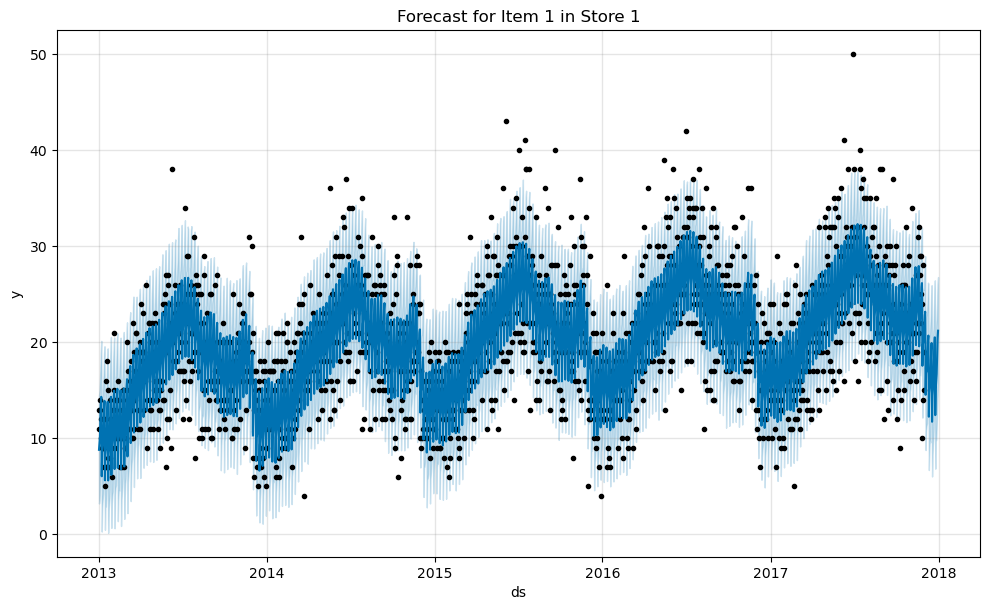

In [86]:
fig = model.plot(forecast)
plt.title(f'Forecast for Item {item} in Store {store}')
plt.show()

# Calculating errors

In [87]:
predicted_sales = forecast.tail(30)['yhat'].values
actual_sales = test_data['y'].values

mse = mean_squared_error(actual_sales, predicted_sales)
mae = mean_absolute_error(actual_sales, predicted_sales)
r2 = r2_score(actual_sales, predicted_sales)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')


MSE: 21.66879125528913
MAE: 3.5802035029972186
R2: 0.2820677319334334


# Predicting Sales for Specific Store and Product

In [88]:
def predict_sales(store, product):
    # Get data for the specific store and product
    df = data[(data['store'] == store) & (data['item'] == product)]
    
    # Prepare data for the model
    df = df[['date', 'sales']]
    df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
    
    # Create and fit the Prophet model
    model = Prophet()
    model.fit(df)
    
    # Predict sales for the next 30 days
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    
    forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
    return forecasted_sales

# Get the total forecasted sales for the next 30 days
store_product_predictions = {}

for store in data['store'].unique():
    for product in data['item'].unique():
        store_product_predictions[(store, product)] = predict_sales(store, product)


19:55:07 - cmdstanpy - INFO - Chain [1] start processing
19:55:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:55:08 - cmdstanpy - INFO - Chain [1] start processing
19:55:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:55:21 - cmdstanpy - INFO - Chain [1] start processing
19:55:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:55:21 - cmdstanpy - INFO - Chain [1] start processing
19:55:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:55:34 - cmdstanpy - INFO - Chain [1] start processing
19:55:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:55:35 - cmdstanpy - INFO - Chain [1] start processing
19:55:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:55:48 - cmdstanpy - INFO - Chain [1] start processing
19:55:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:55:49 - cmdstanpy - INFO - Chain [1] start processing
19:55:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:56:02 - cmdstanpy - INFO - Chain [1] start processing
19:56:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:56:03 - cmdstanpy - INFO - Chain [1] start processing
19:56:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:56:16 - cmdstanpy - INFO - Chain [1] start processing
19:56:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:56:17 - cmdstanpy - INFO - Chain [1] start processing
19:56:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:56:29 - cmdstanpy - INFO - Chain [1] start processing
19:56:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:56:30 - cmdstanpy - INFO - Chain [1] start processing
19:56:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:56:43 - cmdstanpy - INFO - Chain [1] start processing
19:56:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:56:44 - cmdstanpy - INFO - Chain [1] start processing
19:56:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:56:56 - cmdstanpy - INFO - Chain [1] start processing
19:56:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:56:57 - cmdstanpy - INFO - Chain [1] start processing
19:56:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:57:10 - cmdstanpy - INFO - Chain [1] start processing
19:57:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:57:10 - cmdstanpy - INFO - Chain [1] start processing
19:57:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:57:23 - cmdstanpy - INFO - Chain [1] start processing
19:57:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:57:24 - cmdstanpy - INFO - Chain [1] start processing
19:57:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:57:36 - cmdstanpy - INFO - Chain [1] start processing
19:57:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:57:37 - cmdstanpy - INFO - Chain [1] start processing
19:57:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:57:50 - cmdstanpy - INFO - Chain [1] start processing
19:57:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:57:51 - cmdstanpy - INFO - Chain [1] start processing
19:57:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:58:04 - cmdstanpy - INFO - Chain [1] start processing
19:58:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:58:04 - cmdstanpy - INFO - Chain [1] start processing
19:58:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:58:18 - cmdstanpy - INFO - Chain [1] start processing
19:58:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:58:19 - cmdstanpy - INFO - Chain [1] start processing
19:58:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:58:31 - cmdstanpy - INFO - Chain [1] start processing
19:58:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:58:32 - cmdstanpy - INFO - Chain [1] start processing
19:58:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:58:45 - cmdstanpy - INFO - Chain [1] start processing
19:58:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:58:46 - cmdstanpy - INFO - Chain [1] start processing
19:58:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:58:58 - cmdstanpy - INFO - Chain [1] start processing
19:58:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:58:59 - cmdstanpy - INFO - Chain [1] start processing
19:58:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:59:12 - cmdstanpy - INFO - Chain [1] start processing
19:59:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:59:13 - cmdstanpy - INFO - Chain [1] start processing
19:59:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:59:26 - cmdstanpy - INFO - Chain [1] start processing
19:59:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:59:27 - cmdstanpy - INFO - Chain [1] start processing
19:59:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:59:39 - cmdstanpy - INFO - Chain [1] start processing
19:59:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:59:40 - cmdstanpy - INFO - Chain [1] start processing
19:59:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

19:59:53 - cmdstanpy - INFO - Chain [1] start processing
19:59:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
19:59:54 - cmdstanpy - INFO - Chain [1] start processing
19:59:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:00:06 - cmdstanpy - INFO - Chain [1] start processing
20:00:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:00:07 - cmdstanpy - INFO - Chain [1] start processing
20:00:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:00:20 - cmdstanpy - INFO - Chain [1] start processing
20:00:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:00:21 - cmdstanpy - INFO - Chain [1] start processing
20:00:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:00:33 - cmdstanpy - INFO - Chain [1] start processing
20:00:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:00:34 - cmdstanpy - INFO - Chain [1] start processing
20:00:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:00:47 - cmdstanpy - INFO - Chain [1] start processing
20:00:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:00:48 - cmdstanpy - INFO - Chain [1] start processing
20:00:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:01:01 - cmdstanpy - INFO - Chain [1] start processing
20:01:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:01:02 - cmdstanpy - INFO - Chain [1] start processing
20:01:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:01:15 - cmdstanpy - INFO - Chain [1] start processing
20:01:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:01:16 - cmdstanpy - INFO - Chain [1] start processing
20:01:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:01:30 - cmdstanpy - INFO - Chain [1] start processing
20:01:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:01:30 - cmdstanpy - INFO - Chain [1] start processing
20:01:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:01:44 - cmdstanpy - INFO - Chain [1] start processing
20:01:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:01:45 - cmdstanpy - INFO - Chain [1] start processing
20:01:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:01:58 - cmdstanpy - INFO - Chain [1] start processing
20:01:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:01:59 - cmdstanpy - INFO - Chain [1] start processing
20:01:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

20:02:12 - cmdstanpy - INFO - Chain [1] start processing
20:02:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:02:12 - cmdstanpy - INFO - Chain [1] start processing
20:02:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

# Display predictions

In [89]:
for key, value in store_product_predictions.items():
    print(f"Store {key[0]}, Product {key[1]}: Expected Sales for Next Month = {value}")

Store 1, Product 1: Expected Sales for Next Month = 509.23818090368206
Store 1, Product 2: Expected Sales for Next Month = 1409.0487330653946
Store 1, Product 3: Expected Sales for Next Month = 865.6704017994759
Store 1, Product 4: Expected Sales for Next Month = 507.6923758284947
Store 1, Product 5: Expected Sales for Next Month = 436.9036305707466
Store 1, Product 6: Expected Sales for Next Month = 1388.0334602736068
Store 1, Product 7: Expected Sales for Next Month = 1353.0565658522466
Store 1, Product 8: Expected Sales for Next Month = 1845.6987396732245
Store 1, Product 9: Expected Sales for Next Month = 1179.05180973459
Store 1, Product 10: Expected Sales for Next Month = 1780.5078839066616
Store 1, Product 11: Expected Sales for Next Month = 1671.6731884159249
Store 1, Product 12: Expected Sales for Next Month = 1656.1953296551721
Store 1, Product 13: Expected Sales for Next Month = 1955.5392136537141
Store 1, Product 14: Expected Sales for Next Month = 1368.1418892962583
Store 

# Predict Sales for a Specific Item Across All Stores

In [90]:
def predict_sales_for_item(item):
    store_product_predictions = {}
    
    # Loop through each store to predict sales for the given item
    for store in data['store'].unique():
        # Predict sales for the current store and the given item
        forecasted_sales = predict_sales(store, item)
        store_product_predictions[store] = forecasted_sales

    return store_product_predictions


In [91]:
# Specify the item number you are interested in
item_number = 1

# Get sales predictions for the specified item across all stores
predictions = predict_sales_for_item(item_number)

20:02:15 - cmdstanpy - INFO - Chain [1] start processing
20:02:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
20:02:16 - cmdstanpy - INFO - Chain [1] start processing
20:02:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_10944\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = 

# Display predictions

In [92]:
for store, value in predictions.items():
    print(f"Store {store}: Expected Sales for Item {item_number} in the Next Month = {value}")

Store 1: Expected Sales for Item 1 in the Next Month = 509.23818090368206
Store 2: Expected Sales for Item 1 in the Next Month = 736.6282924509842
Store 3: Expected Sales for Item 1 in the Next Month = 670.6874680161861
Store 4: Expected Sales for Item 1 in the Next Month = 596.7754017473383
Store 5: Expected Sales for Item 1 in the Next Month = 448.37097713123035
Store 6: Expected Sales for Item 1 in the Next Month = 417.38174636757424
Store 7: Expected Sales for Item 1 in the Next Month = 394.8066353240859
Store 8: Expected Sales for Item 1 in the Next Month = 690.761155662511
Store 9: Expected Sales for Item 1 in the Next Month = 610.5894080417697
Store 10: Expected Sales for Item 1 in the Next Month = 642.6937223823794


# Forecasting Sales for All Items and Stores

In [ ]:
unique_items = store_item_groups['item'].unique()
unique_stores = store_item_groups['store'].unique()

results = []

for item in unique_items:
    for store in unique_stores:
        ts_data = prepare_timeseries_data(data, item, store)
        if ts_data.shape[0] > 0: # Ensure data is not empty
            model = Prophet()
            model.fit(ts_data)
            
            future = model.make_future_dataframe(periods=30)
            forecast = model.predict(future)
            
            results.append({
                'item': item,
                'store': store,
                'forecast': forecast[['ds', 'yhat']].tail(30).to_dict('records')
            })

20:02:24 - cmdstanpy - INFO - Chain [1] start processing
20:02:24 - cmdstanpy - INFO - Chain [1] done processing
20:02:25 - cmdstanpy - INFO - Chain [1] start processing
20:02:25 - cmdstanpy - INFO - Chain [1] done processing
20:02:26 - cmdstanpy - INFO - Chain [1] start processing
20:02:26 - cmdstanpy - INFO - Chain [1] done processing
20:02:26 - cmdstanpy - INFO - Chain [1] start processing
20:02:26 - cmdstanpy - INFO - Chain [1] done processing
20:02:27 - cmdstanpy - INFO - Chain [1] start processing
20:02:27 - cmdstanpy - INFO - Chain [1] done processing
20:02:28 - cmdstanpy - INFO - Chain [1] start processing
20:02:28 - cmdstanpy - INFO - Chain [1] done processing
20:02:29 - cmdstanpy - INFO - Chain [1] start processing
20:02:29 - cmdstanpy - INFO - Chain [1] done processing
20:02:30 - cmdstanpy - INFO - Chain [1] start processing
20:02:30 - cmdstanpy - INFO - Chain [1] done processing
20:02:30 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1]

20:03:26 - cmdstanpy - INFO - Chain [1] done processing
20:03:27 - cmdstanpy - INFO - Chain [1] start processing
20:03:27 - cmdstanpy - INFO - Chain [1] done processing
20:03:28 - cmdstanpy - INFO - Chain [1] start processing
20:03:28 - cmdstanpy - INFO - Chain [1] done processing
20:03:29 - cmdstanpy - INFO - Chain [1] start processing
20:03:29 - cmdstanpy - INFO - Chain [1] done processing
20:03:30 - cmdstanpy - INFO - Chain [1] start processing
20:03:30 - cmdstanpy - INFO - Chain [1] done processing
20:03:31 - cmdstanpy - INFO - Chain [1] start processing
20:03:31 - cmdstanpy - INFO - Chain [1] done processing
20:03:32 - cmdstanpy - INFO - Chain [1] start processing
20:03:32 - cmdstanpy - INFO - Chain [1] done processing
20:03:33 - cmdstanpy - INFO - Chain [1] start processing
20:03:33 - cmdstanpy - INFO - Chain [1] done processing
20:03:34 - cmdstanpy - INFO - Chain [1] start processing
20:03:34 - cmdstanpy - INFO - Chain [1] done processing
20:03:35 - cmdstanpy - INFO - Chain [1] 

20:04:31 - cmdstanpy - INFO - Chain [1] done processing
20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing
20:04:33 - cmdstanpy - INFO - Chain [1] start processing
20:04:33 - cmdstanpy - INFO - Chain [1] done processing
20:04:34 - cmdstanpy - INFO - Chain [1] start processing
20:04:34 - cmdstanpy - INFO - Chain [1] done processing
20:04:35 - cmdstanpy - INFO - Chain [1] start processing
20:04:35 - cmdstanpy - INFO - Chain [1] done processing
20:04:36 - cmdstanpy - INFO - Chain [1] start processing
20:04:36 - cmdstanpy - INFO - Chain [1] done processing
20:04:37 - cmdstanpy - INFO - Chain [1] start processing
20:04:37 - cmdstanpy - INFO - Chain [1] done processing
20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] done processing
20:04:39 - cmdstanpy - INFO - Chain [1] start processing
20:04:39 - cmdstanpy - INFO - Chain [1] done processing
20:04:40 - cmdstanpy - INFO - Chain [1] 

20:05:42 - cmdstanpy - INFO - Chain [1] done processing
20:05:42 - cmdstanpy - INFO - Chain [1] start processing
20:05:43 - cmdstanpy - INFO - Chain [1] done processing
20:05:43 - cmdstanpy - INFO - Chain [1] start processing
20:05:43 - cmdstanpy - INFO - Chain [1] done processing
20:05:44 - cmdstanpy - INFO - Chain [1] start processing
20:05:44 - cmdstanpy - INFO - Chain [1] done processing
20:05:45 - cmdstanpy - INFO - Chain [1] start processing
20:05:45 - cmdstanpy - INFO - Chain [1] done processing
20:05:46 - cmdstanpy - INFO - Chain [1] start processing
20:05:46 - cmdstanpy - INFO - Chain [1] done processing
20:05:47 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing
20:05:48 - cmdstanpy - INFO - Chain [1] start processing
20:05:48 - cmdstanpy - INFO - Chain [1] done processing
20:05:48 - cmdstanpy - INFO - Chain [1] start processing
20:05:48 - cmdstanpy - INFO - Chain [1] done processing
20:05:49 - cmdstanpy - INFO - Chain [1] 

20:06:47 - cmdstanpy - INFO - Chain [1] done processing
20:06:48 - cmdstanpy - INFO - Chain [1] start processing
20:06:48 - cmdstanpy - INFO - Chain [1] done processing
20:06:49 - cmdstanpy - INFO - Chain [1] start processing
20:06:49 - cmdstanpy - INFO - Chain [1] done processing
20:06:50 - cmdstanpy - INFO - Chain [1] start processing
20:06:50 - cmdstanpy - INFO - Chain [1] done processing
20:06:51 - cmdstanpy - INFO - Chain [1] start processing
20:06:51 - cmdstanpy - INFO - Chain [1] done processing
20:06:52 - cmdstanpy - INFO - Chain [1] start processing
20:06:52 - cmdstanpy - INFO - Chain [1] done processing
20:06:53 - cmdstanpy - INFO - Chain [1] start processing
20:06:53 - cmdstanpy - INFO - Chain [1] done processing
20:06:54 - cmdstanpy - INFO - Chain [1] start processing
20:06:54 - cmdstanpy - INFO - Chain [1] done processing
20:06:55 - cmdstanpy - INFO - Chain [1] start processing
20:06:55 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] 

20:07:55 - cmdstanpy - INFO - Chain [1] done processing
20:07:56 - cmdstanpy - INFO - Chain [1] start processing
20:07:56 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:58 - cmdstanpy - INFO - Chain [1] done processing
20:07:58 - cmdstanpy - INFO - Chain [1] start processing
20:07:58 - cmdstanpy - INFO - Chain [1] done processing
20:07:59 - cmdstanpy - INFO - Chain [1] start processing
20:07:59 - cmdstanpy - INFO - Chain [1] done processing
20:08:00 - cmdstanpy - INFO - Chain [1] start processing
20:08:00 - cmdstanpy - INFO - Chain [1] done processing
20:08:01 - cmdstanpy - INFO - Chain [1] start processing
20:08:01 - cmdstanpy - INFO - Chain [1] done processing
20:08:02 - cmdstanpy - INFO - Chain [1] start processing
20:08:02 - cmdstanpy - INFO - Chain [1] done processing
20:08:03 - cmdstanpy - INFO - Chain [1] 

20:08:58 - cmdstanpy - INFO - Chain [1] done processing
20:08:59 - cmdstanpy - INFO - Chain [1] start processing
20:08:59 - cmdstanpy - INFO - Chain [1] done processing
20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:00 - cmdstanpy - INFO - Chain [1] done processing
20:09:01 - cmdstanpy - INFO - Chain [1] start processing
20:09:01 - cmdstanpy - INFO - Chain [1] done processing
20:09:02 - cmdstanpy - INFO - Chain [1] start processing
20:09:02 - cmdstanpy - INFO - Chain [1] done processing
20:09:02 - cmdstanpy - INFO - Chain [1] start processing
20:09:03 - cmdstanpy - INFO - Chain [1] done processing
20:09:03 - cmdstanpy - INFO - Chain [1] start processing
20:09:03 - cmdstanpy - INFO - Chain [1] done processing
20:09:04 - cmdstanpy - INFO - Chain [1] start processing
20:09:04 - cmdstanpy - INFO - Chain [1] done processing
20:09:05 - cmdstanpy - INFO - Chain [1] start processing
20:09:05 - cmdstanpy - INFO - Chain [1] done processing
20:09:06 - cmdstanpy - INFO - Chain [1] 

# Display results

In [ ]:
for result in results:
    print(f"Item {result['item']} in Store {result['store']}")
    print(pd.DataFrame(result['forecast']).head())
